# **Grammar Error Detection using BERT**


***FIne tune BERT model with CoLA dataset for single sentence classification task***

Sunil Chomal | sunilchomal@gmail.com

In [24]:
%%html
<img src='/nbextensions/google.colab/GED.png' />

•	We use the bert-base-uncased as the pre trained model. It consists of 12-layer, 768-hidden, 12-heads, 110M parameters and is trained on lower-cased English text. 

•	For fine-tuning we have used CoLA dataset for single sentence classification. 

•	BertForSequenceClassification is a BERT model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output). 

•	We trained the network for 4 epochs, and on Google Colab with a Tesla K80 GPU, it takes about 25 minutes. After training we get a training loss of 0.1 and a validation accuracy of 0.81.

•	Using the out of domain validation data to calculate the Matthews correlation coefficient, we achieve a value of 0.44


In [42]:
import tensorflow as tf

# Check to confirm that GPU is available
device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError ('GPU device not found')

print('Found GPU at: {}'.format(device_name))



Found GPU at: 


In [26]:
# install pytorch_pretrained_bert the previous version of Pytorch-Transformers
#!pip install pytorch-pretrained-bert

In [43]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm , trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# Check to confirm the specific GPU model
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070 Laptop GPU'

In [45]:
# Download Data
# source: https://nyu-mll.github.io/CoLA
# from google.colab import files
# uploaded = files.upload()

In [46]:
# Get CoLA dataset from its official source

#!wget https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
#!unzip cola_public_1.1.zip 
#!cp ./cola_public/raw/in_domain_train.tsv .
#!cp ./cola_public/raw/out_of_domain_dev.tsv .

In [47]:
#Move Data to a Panda DataFrame
df = pd.read_csv ('train.tsv', delimiter='\t', header=None, encoding='cp850',
                  names=['text', 'label'])

df.shape

df[:3]

,text,label
0,"en route , they pick up a seemingly-harmless h...",1
1,"en route , they pick up a seemingly-harmless h...",0
2,"jobs, however, are not created by supporting a...",1


In [48]:
# Sentence and Label Lists
df = df[:20000]
sentences = df.text.values
sentences = ["[CLS]" + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [49]:
# Tokenize Inputs

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case = True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize version of the the first sentence:")
print(tokenized_texts[0])

Tokenize version of the the first sentence:
['[', 'cl', '##s', ']', 'en', 'route', ',', 'they', 'pick', 'up', 'a', 'seemingly', '-', 'harmless', 'hitch', '##hi', '##ker', ',', 'and', 'continue', 'their', 'journey', ',', 'only', 'for', 'their', 'car', 'to', 'break', 'down', 'in', 'a', 'deserted', 'motel', 'on', 'a', 'lonely', 'highway', '.', '[SEP]']


In [50]:
# Padding Sentences
# Set the maximum sequence length. The longest sequence in our training set
# is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Pad our input tokens
input_ids = pad_sequences(
    [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts], 
    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"
    )

# Index Numbers and Padding
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# pad sentences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype ="long", truncating="post",padding ="post")


In [51]:
# Attention masks

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)


In [52]:
# Train and Validation Set

train_inputs, validation_inputs, train_labels, validation_labels = \
  train_test_split(input_ids, labels, random_state=2018, test_size=0.1)

train_masks, validation_masks , _, _ = \
  train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)
  
# transform all data into torch tensors

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [53]:
# Preparation for Training

# Select a batch size for training. For fine tuning BERT on a
# specific task , BERT authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader
# This helps save on memory during training because, unlike a for loop, 
# with iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = \
  DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = \
  TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = \
  DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [54]:
# Load BertForSequenceClassification, the pretrained BERT model
# with a single linear classification layer on top

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                      num_labels=2)

model.cuda()

RuntimeError: CUDA out of memory. Tried to allocate 90.00 MiB (GPU 0; 8.00 GiB total capacity; 6.24 GiB already allocated; 0 bytes free; 6.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [39]:
# Hyperparameters

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']

optimizer_grouped_parameters = [
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01
    },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 
        'weight_decay_rate': 0.00
    }
  ]

optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=0.1)

t_total value of -1 results in schedule not being applied


In [40]:
# calculates the accuracy of our predictions vs labels

def flat_accuracy(preds, labels):
  pred_flat  = np.argmax(preds , axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat)/len(labels_flat)


In [41]:
# Training Loop

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask , b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, 
                 attention_mask=b_input_mask, labels=b_labels)
    
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
# Validation
# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Tracking variables
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients,
  # ve memory and speede up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids =None, attention_mask=b_input_mask)
    
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  tmp_eval_accuracy = flat_accuracy(logits, label_ids)
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1

print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 8.00 GiB total capacity; 6.24 GiB already allocated; 0 bytes free; 6.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

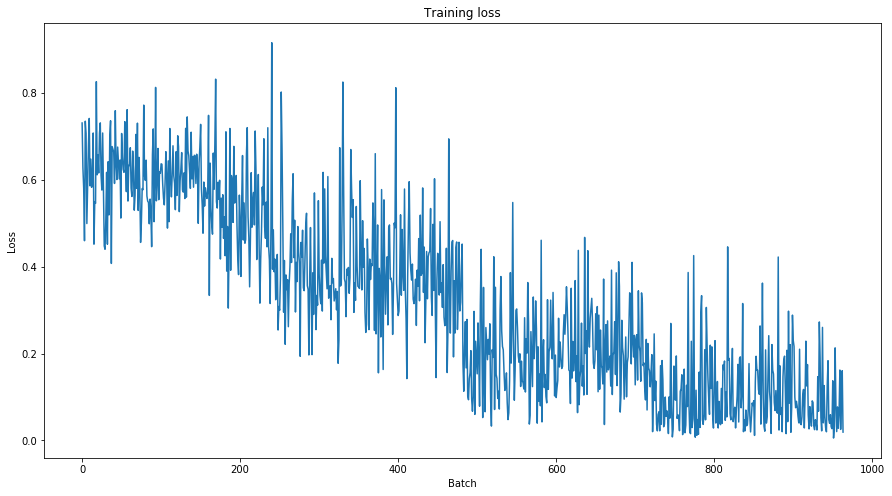

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
# Predict and Evaluate on Holdout Set

# Upload the test file from your local drive
# from google.colab import files 
# uploaded = files.upload()

In [ ]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None,
  names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence) and label lists
sentences = df.sentence.values
# We need to add special tokens at the beginning and end of each sentence
# for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# Padding Sentences
# Set the maximum sequence length. The longest sequence in our training set
# is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Pad our input tokens
input_ids = pad_sequences(
    [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts], 
    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"
    )

# Index Numbers and Padding
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# pad sentences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype ="long", truncating="post",padding ="post")

# Attention masks

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = \
  TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = \
  DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [ ]:
# Prediction on the test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask , b_labels = batch
  # Telling the model not to compute or store gradients,
  # saving memory and speeding up prediction

  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to("cpu").numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
# Evaluate Each Test Batch using Matthew's correlation coefficient

from sklearn.metrics import matthews_corrcoef 

matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i], 
                               np.argmax(predictions[i], axis=1).flatten())

  matthews_set.append(matthews)

matthews_set

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[-0.2135744251723958,
 -0.2548235957188128,
 0.20513587275572404,
 0.38164251207729466,
 0.41281272698065485,
 0.8050112948805689,
 0.37777777777777777,
 0.29277002188455997,
 0.7419408268023742,
 0.4700159919404217,
 0.6777749493656265,
 0.6457765999379483,
 0.6979824404521128,
 0.7948717948717948,
 0.38461538461538464,
 0.42276002160669474,
 0.0]

In [ ]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

matthews_corrcoef(flat_true_labels , flat_predictions)

0.4425287491325227

In [ ]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

torch.save(model.state_dict(), 'bert-based-uncased-GED.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp bert-based-uncased-GED.pth './drive/My Drive/Colab Notebooks/S89A'

In [ ]:
# run on a sample text

model.eval()

# Create sentence) and label lists
sentences = ["They drank the pub."]
# We need to add special tokens at the beginning and end of each sentence
# for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels =[0]

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# Padding Sentences
# Set the maximum sequence length. The longest sequence in our training set
# is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

predictions = []
true_labels = []

# Pad our input tokens
input_ids = pad_sequences(
    [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts], 
    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"
    )

# Index Numbers and Padding
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# pad sentences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype ="long", truncating="post",padding ="post")

# Attention masks

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Put model in evaluation mode
model.eval()

with torch.no_grad():
  # Forward pass, calculate logit predictions
  logits = model(prediction_inputs.to(device), token_type_ids=None, attention_mask=prediction_masks.to(device))

# Move logits and labels to CPU
logits = logits.detach().cpu().numpy()
label_ids = b_labels.to("cpu").numpy()

# Store predictions and true labels
predictions.append(logits)
true_labels.append(label_ids)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [ ]:
flat_predictions[0]

0